In [1]:
# maker sure all the packages are installed before running the notebook.

In [2]:
import pandas as pd
import tabula
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.select import Select
import time
import warnings
import numpy as np
import re
import csv

warnings.filterwarnings('ignore')

In [3]:
class Datatool():
    
    def __int__(self):
        pass
    
    def getId(self):
        """
        This funciton scrapes all reportId from the crudemonitor database, 
                which will be used to collect data
        Reture: List[str]
        """
        reportId = []

        driver = webdriver.Safari()
        page = driver.get('https://crudemonitor.ca/library/')
        crudes = Select(driver.find_element("xpath","//select[contains(@name, 'crude')]")).options

        for i in range(1,2):
            # item 23 does not exist.
            if i != 23:
                crudes[i].click()
                time.sleep(5)
                try:
                    dates = Select(driver.find_element("xpath","//select[contains(@name, 'date')]")).options
                    for date in dates[1:2]:
                        reportId.append(date.get_attribute("value"))
                except:
                    pass
        return reportId
    
    def _saveId(self):
        """
        This function saves the reportIds to a csv file for future use
        """
        reprotIds = self.getId()
        with open('reports.csv', 'w') as f:
            for report in reportIds:
                f.write(f"{report}\n")
                
    def _parse(self, strId):
        """
        This function parses the reportId
        Return: str
        """
        return re.findall(r'[A-Za-z]+|\d+',strId)[0]
    
    def getTable(self, strId):
        """
        This function use the reported Id to collect data from pdf links
        Reture: List[DataFrame]
        """
        shortId = self._parse(strId)
        url = f'https://crudemonitor.ca/library/archives/batch/{shortId}/{strId}.pdf'

        try:  
            df = tabula.read_pdf(url, pages='all',multiple_tables=True)
            # get first half of the distillation profile
            distil = df[0].iloc[:,4:]

            # get the second half of the distillation profile
            temp = df[1].T.reset_index().T.iloc[:,3:8].dropna(thresh=3)
            distil2 = temp.iloc[:11].iloc[:,:-1]
            distil2.columns = distil.columns.tolist()
            distil = distil.append(distil2, ignore_index=True)

            # convert to float and filling missing values with 2000 
            # (a temperature about 3 times higher than the end temperature)
            distil.set_index('% Off', inplace = True)
            distil = distil.applymap(lambda x: float(x) if x!='-' else 2000)

            # get composition
            comp = temp.iloc[11:17].drop(4,axis=1)
            comp.columns = ['Composition','Obs','His','Std']
            comp.set_index('Composition', inplace=True)

            return [distil, comp]
        
        except:
            return None
        
    def getData(self):
        """
        This funtion convert all the data to np.array
        """
        reports = []
        with open("reportId.csv", "r") as f:
            reader = csv.reader(f)
            for line in reader:
                reports.append(line[0])
            
        X = []
        y = []
        i = 0
        while len(X)<500:
            report =  reports[i]
            try:
                res = self.getTable(report)
                print(report, len(X))
                if res and res[1]['His'].tolist()[0] != 'Past Avg':
                    X.append(np.array(res[0].iloc[:-2,1].tolist()))
                    y.append(np.array(res[1]['His'].tolist(),dtype = float))
            except:
                pass
            i += 1
        return np.array(X), np.array(y)
        
        


The cell below performs the data collection and transformation. It will take time to collect the data.
The data are stored in .csv files for easier access.

In [4]:
# data = Datatool()
# X,y = data.getData()
# np.savetxt('X.csv',X, delimiter=',')
# np.savetxt('y.csv',y, delimiter=',')

In [5]:
# if we only use the %off at [ 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99], the shape will be (500,12)
X = np.loadtxt('X.csv', delimiter=",")
X.shape

(500, 22)

In [6]:
y = np.loadtxt('y.csv', delimiter=",")
y.shape

(500, 6)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#### Model A

- First, create a model to predict crude oil compositon using distillation profile. In other words creat a linear model to map the dataset from (500,22) to (500,6).
- Two different models are used, the regularized linear model (Lasso) and a five-layer neural network
- Regularization and dropout layers are added to prevent overfitting.
- MAE is used as the metric, and adam is the optimizer.
- Both models were able to predict the composition fairly accurately, NN performs slightly better.

Text(0.5, 0.04, 'Prediction')

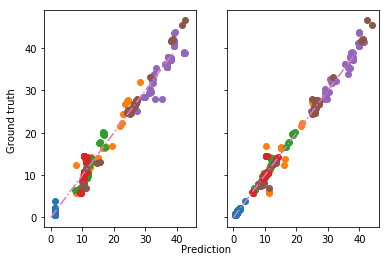

In [9]:
scalerA = StandardScaler()
X_trainA = scalerA.fit_transform(X_train)
X_testA = scalerA.transform(X_test)

modelA_v1 = Lasso()

modelA_v2 = Sequential()
modelA_v2.add(Dense(64, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))
# The Hidden Layers :
modelA_v2.add(Dense(128, kernel_initializer='normal',activation='relu'))
modelA_v2.add(Dropout(0.2))
modelA_v2.add(Dense(128, kernel_initializer='normal',activation='relu'))
modelA_v2.add(Dropout(0.2))
modelA_v2.add(Dense(64, kernel_initializer='normal',activation='relu'))
# The Output Layer :
modelA_v2.add(Dense(y_train.shape[1], kernel_initializer='normal',activation='linear'))
# Compile the network :
modelA_v2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

modelA_v1.fit(X_trainA,y_train)
modelA_v2.fit(X_trainA,y_train, epochs=100, batch_size=32, verbose=0)


fig, ax = plt.subplots(1,2, sharey=True, sharex=True)
ax[0].plot(modelA_v1.predict(X_testA), y_test,'o')
ax[0].plot(np.arange(0,40,1),np.arange(0,40,1),'-.')
ax[1].plot(modelA_v2.predict(X_testA), y_test,'o')
ax[1].plot(np.arange(0,40,1),np.arange(0,40,1),'-.')

fig.text(0.04, 0.5, 'Ground truth', va='center', rotation='vertical')
fig.text(0.5, 0.04,  'Prediction', ha='center')

#### Model B

- Now we create a model to predict crude oil distillation profile based on the calculated compositon. In other words creat a linear model to map the dataset from (500,6) back to (500,22).
- It seems the NN model can provide good prediction when then temperature is below ~600 ˚C, above this temperature, because some crude oil stoped distilling and we used T=2000 to represent non-volatile. This caused the model to mispredict the distilling profile at higher temperatures.
- Nonetheless, we can still use the NN model to estimate the boiling profile of the blend.

Text(0.5, 0.04, 'Prediction')

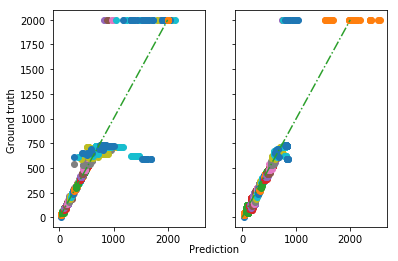

In [10]:
scalerB = StandardScaler()
X_trainB = scalerB.fit_transform(y_train)
X_testB = scalerB.transform(y_test)

modelB_v1 = Lasso()

modelB_v2 = Sequential()
modelB_v2.add(Dense(64, kernel_initializer='normal',input_dim = y_train.shape[1], activation='relu'))
# The Hidden Layers :
modelB_v2.add(Dense(128, kernel_initializer='normal',activation='relu'))
modelB_v2.add(Dropout(0.2))
modelB_v2.add(Dense(128, kernel_initializer='normal',activation='relu'))
modelB_v2.add(Dropout(0.2))
modelB_v2.add(Dense(64, kernel_initializer='normal',activation='relu'))
# The Output Layer :
modelB_v2.add(Dense(X_train.shape[1], kernel_initializer='normal',activation='linear'))
# Compile the network :
modelB_v2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

modelB_v1.fit(X_trainB,X_train)
modelB_v2.fit(X_trainB,X_train, epochs=100, batch_size=32, verbose=0)


fig, ax = plt.subplots(1,2, sharey=True, sharex=True)
ax[0].plot(modelB_v1.predict(X_testB), X_test,'o')
ax[0].plot(np.arange(0,2000,1),np.arange(0,2000,1),'-.')
ax[1].plot(modelB_v2.predict(X_testB), X_test,'o')
ax[1].plot(np.arange(0,2000,1),np.arange(0,2000,1),'-.')

fig.text(0.02, 0.5, 'Ground truth', va='center', rotation='vertical')
fig.text(0.5, 0.04,  'Prediction', ha='center')

#### Put it all together

- Our input will be two arrays of floats (1,22) or (1,12) depending on the distillation profiled used. For simplicity, I will keep using (1,22). *__change the getTable method in the Datatool class in order to use (1,12)__*. We used ModelA to map two (1,22) arrays to two (1,6) arrays to get the corresponding compositions of the starting crude oils. 
- Once we have the estimated compositions, we can calculated the compositon of the blend using the blending factor.
- Then, we use ModelB to map the calculated blend composition (1,6) back to distillation profile (1,22)
- Cutoff. As can be seen from the figure above, if the temperature is > 1000 ˚C, the blend can be considered as non-volatile.

Below is an example using data from Crude Moniter data
    A is BG past Avg(Feb 04, 2008), B is AWB past Avg(Jun 29, 2010)
- https://crudemonitor.ca/library/archives/batch/BG/BG080204.pdf
- https://crudemonitor.ca/library/archives/batch/AWB/AWB100629.pdf
- A: [28.0, 29.0, 52.7, 78.7, 95.9, 117.9, 139.9, 160.2, 182.4, 207.9, 235.7, 264.8, 294.2, 393.3, 432.0, 478.7, 545.2, 571.4, 619.2, 670.9, 685.2, 2000, 703.4, 7.42]
- B: [34.2, 34.7, 46.8, 82.5, 139.5, 235.4, 306.0, 350.8, 390.0, 426.4, 461.2, 498.3, 538.6, 658.7, 685.7, 708.9, 719.0, 2000, 2000, 2000, 2000, 2000, 716.8, 21.23]
    

In [11]:
# predict composition using ModelA, Note 60% and 65% are not included.
a = np.array([28.0, 29.0, 52.7, 78.7, 95.9, 117.9, 139.9, 160.2, 182.4, 207.9, 235.7, 
     264.8, 294.2, 393.3, 432.0, 478.7, 545.2, 571.4, 619.2, 
     670.9, 685.2, 2000]).reshape(1,22)
b = np.array([34.2, 34.7, 46.8, 82.5, 139.5, 235.4, 306.0, 350.8, 390.0, 426.4, 461.2,
     498.3, 538.6, 658.7, 685.7, 708.9, 719.0, 2000, 2000, 2000,
     2000, 2000]).reshape(1,22)

compA = modelA_v2.predict(scalerA.transform(a))
compB = modelA_v2.predict(scalerA.transform(b))

The real compositions from reprot are 
   - A: [3.9, 31.8, 16.6, 10.7, 24.9, 12.0]
   - B: [0.7, 16.3, 6.9, 6.0, 28.4, 41.7]
   
Model Prediction

   - A: [3.7, 31.0, 16.5, 11.0, 24.5, 11.6, 

In [26]:
compA

array([[ 3.6777358, 31.041422 , 16.545374 , 10.984558 , 24.545212 ,
        11.615576 ]], dtype=float32)

In [13]:
compB

array([[ 0.5414856, 15.074337 ,  6.677154 ,  6.200453 , 29.426668 ,
        40.399548 ]], dtype=float32)

In [14]:
# Calculate the blend composition using 0.3 A and 0.7 B
blend = 0.8*compA + 0.2*compB
blend

array([[ 3.0504858, 27.848005 , 14.571731 , 10.027737 , 25.521503 ,
        17.37237  ]], dtype=float32)

In [15]:
# Now we use ModelB to predict the distillation profile of the blend
profile = modelB_v2.predict(scalerB.transform(blend))
finalProfile = [x if x<1000 else np.nan for x in profile[0]]

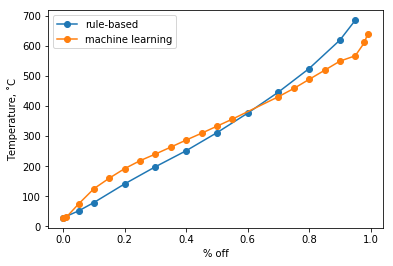

In [16]:
plt.plot([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1],[29.24, 51.52, 79.46, 141.4, 198.32, 251.6, 311.5, 376.4, 446.38, 524.74, 619.2, 685.2, np.nan], 'o-')
plt.plot([0, 0.01, 0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.7,0.75,0.8,0.85,0.9,0.95,0.98,0.99,1],finalProfile, 'o-')
plt.xlabel('% off')
plt.ylabel('Temperature, ˚C')
plt.legend(['rule-based','machine learning'])

The shape of the machine learning prediction looks more promissing, we try to estimate the model error below by looking at the differences between ground truth values and prediction values.

In [17]:
x_total = scalerA.transform(X)
predA = modelA_v2.predict(x_total)
predB = modelB_v2.predict(scalerB.transform(predA))
predB = np.vectorize(lambda x: x if x<1000 else np.nan)(predB)
X = np.vectorize(lambda x: x if x<1000 else np.nan)(X)
error = []
for i in range(len(predB[0])):
    error.append((predB-X)[:,i].std())
error

[2.68767333627492,
 3.445382464293239,
 19.983404883804315,
 28.712370382173205,
 30.10502164776045,
 25.794937051208535,
 25.146920199179913,
 25.897464508183393,
 25.73345241327163,
 24.427222979827306,
 22.48348222072557,
 19.869175116466202,
 18.062647868827323,
 15.706295541292636,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [18]:
finalProfile

[28.22507,
 30.510489,
 74.53479,
 125.42563,
 160.45396,
 192.11787,
 218.4734,
 240.49405,
 263.5954,
 287.04825,
 309.64847,
 333.04193,
 356.43518,
 431.06354,
 458.36417,
 488.69385,
 518.81085,
 549.2564,
 567.0789,
 611.3895,
 639.63513,
 nan]